<a href="https://colab.research.google.com/github/boscodeeromeu/NN/blob/main/STUDENT_Lab_3_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 (Part 1): Convolutional NNs for CIFAR 10


------------------------------------------------------
*Neural Networks. Bachelor in Data Science and Engineering*

*Pablo M. Olmos pamartin@ing.uc3m.es*

*Aurora Cobo Aguilera acobo@tsc.uc3m.es*

------------------------------------------------------


In this third part of the lab, we will use a data set of (small) natural images known as  [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Our goal is to present i) how CNN layers are used in Pytorch, and ii) evaluate the performance of a simple CNN over this dataset.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

**IMPORTANT NOTE:** In this notebook I show you how to speed up NN training using Graphical Processing Units (GPUs). To make sure you use a Google Colaboratory server equipped with a GPU, go to `Edit` --> `Notebook Settings` --> Select GPU in `Hardware Accelerator`

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://pytorch.org/tutorials/_images/cifar10.png", width=400, height=300)

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

## Part I. Download CIFAR10 with `torchvision`

The code below will download the CIFAR10 dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [4]:
import torch
from torchvision import datasets, transforms, utils

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
traindata = iter(trainloader)

images, labels = next(traindata)

print(images[1].shape)
#in each element of traindata we have 64 images in rgb format of dimension 32x32

torch.Size([3, 32, 32])


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

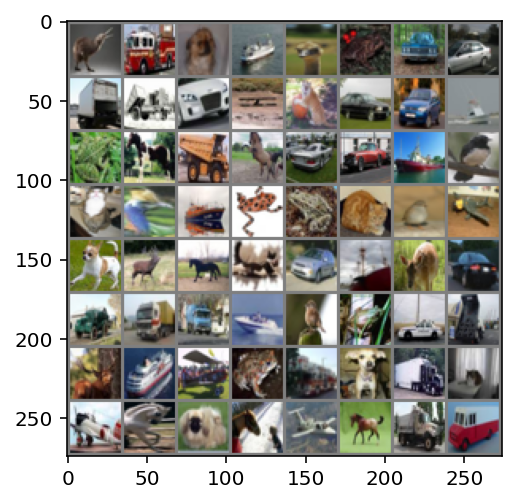

In [7]:
imshow(utils.make_grid(images))

> **Exercise:** Create a validation set using the 20% of train images

In [8]:
import copy
import random

validloader = copy.deepcopy(trainloader)

n_train = trainloader.dataset.data.shape[0]
print(n_train)

trainloader.dataset.data = trainloader.dataset.data[0:round(n_train*0.8)]
trainloader.dataset.targets = trainloader.dataset.targets[0:round(n_train*0.8)]


validloader.dataset.data = validloader.dataset.data[round(n_train*0.8):]
validloader.dataset.targets = validloader.dataset.targets[round(n_train*0.8):]

50000


In [9]:
print(trainloader.dataset.data.shape[0],
  validloader.dataset.data.shape[0])
print(len(trainloader.dataset.targets),
  len(validloader.dataset.targets))

40000 10000
40000 10000


## Part II. Implement Lenet 5

Our first goal is to implement the LeNet 5 CNN network, first published in November 1998. See the original paper [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [10]:
Image(url= "https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg")

In the CNN network above we have 2 convolutional layers with the following properties:

- ReLU activation functions are used as non-linear functions
- Maxpooling with $2\times 2$ kernels is used to reduce the spatial dimension in both layers.
- $5\times 5$ convolutional filters are used. Stride is 1.
- After the second convolutional layer, three dense layers are stacked. 

Note that CIFAR-10 images are composed by **3 input color maps**, each of dimension $32\times32$.

> **Exercise:** Complete the following code that defines the above CNN. But first read the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html) documentation.

In [46]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers

        #according to the schema of the Lenet5 the number of (for conv1):
        # inputs is 400 (16 feature maps of dimension 5x5)
        # outputs is 120
        self.linear1 = nn.Linear(400, 120)
        
        #according to the schema of the Lenet5 the number of outputs 
        #for the second dense layer is 84
        self.linear2 = nn.Linear(120, 84)
        
        #we have 10 output classes
        self.linear3 = nn.Linear(84, 10)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        #as we're using 5x5 kernels we reduce fmaps dimension by 4 at each convolution
        #/2 is due to the pooling layers that halve the dimension of fmaps
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) 
        x = self.relu(x) 
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the tensor into a vector with the appropiate dimension using self.final_dim
        x = x.view(len(x), self.final_dim**2*16)
        #we have len(x) images, so we need a list with len(x) lists. Each of the 
        #len(x) lists is the result of stacking up the 16 fmaps (of dimension self.final_dim)

        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x) 
        return x


Now the network is defined, by now you should know how to move forward by your own!!

> **Exercise:** Extend the class to incorporate a training method, to evaluate the both the validation and train losses and to evaluate the classification performance in a set.

In [55]:
class Lenet5_extended(Lenet5):

  def __init__(self, dimx, nlabels, epochs, lr):
    
    super().__init__(dimx, nlabels)

    self.epochs = epochs

    self.lr = lr

    self.optim = optim.Adam(self.parameters(), self.lr)

    self.criterion = nn.NLLLoss()#we're using LogSoftMax as last activation hence we use 
    # NLLLoss() instead of CrossEntropyFunction

    self.loss_during_training = [] 

    self.valid_loss_during_training = []
  
  def trainloop(self, trainloader, validloader):

    for e in range(int(self.epochs)):

      #to know time per epoch with this configuration
      start_time = time.time()

      running_loss = 0.

      #optimization iteration (epoch)
      for images, labels in trainloader:

        self.optim.zero_grad() #we reset gradients 

        output = self.forward(images)#contrary to the MLP lab, we don't need to flatten images
        # as, obviously, CNNs use 2D inputs

        #we evaluate the loss function
        loss = self.criterion(output, labels)

        running_loss += loss.item()

        # we compute the gradients of the loss function wtr the parameters
        loss.backward()

        #we update the parameters
        self.optim.step()
      
      #we store the loss value for the given epoch
      self.loss_during_training.append(running_loss/len(trainloader))


      #We need to compute the validation loss as well
      with torch.no_grad():#so we save memory and computation time

        running_loss = 0.

        for images, labels in validloader:
          
          output = self.forward(images)

          loss = self.criterion(output, labels)

          running_loss += loss.item()
        
        self.valid_loss_during_training.append(running_loss/len(validloader))
      
      if(e % 1 == 0): # Every epoch

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

  def eval_performance(self,dataloader):
     
     accuracy = 0

     with torch.no_grad():
       
       for images,labels in dataloader:
         
         logprobs = self.forward(images)

         top_p, top_class = logprobs.topk(1, dim=1)
         equals = (top_class == labels.view(images.shape[0], 1))
         accuracy += torch.mean(equals.type(torch.FloatTensor))
    
       return accuracy/len(dataloader)

> **Exercise:** Train the model for 5 epochs, plot the train/validation loss during training, and compute the train and validation performance. It will take some time!!

In [57]:
my_CNN = Lenet5_extended(32, 10, 5, 0.001)
my_CNN.trainloop(trainloader, validloader)

Epoch 0. Training loss: 1.705845, Validation loss: 1.492247, Time per epoch: 16.852168 seconds
Epoch 1. Training loss: 1.413762, Validation loss: 1.348075, Time per epoch: 16.628031 seconds
Epoch 2. Training loss: 1.297650, Validation loss: 1.274681, Time per epoch: 16.629528 seconds
Epoch 3. Training loss: 1.219991, Validation loss: 1.246589, Time per epoch: 16.631365 seconds
Epoch 4. Training loss: 1.157989, Validation loss: 1.222544, Time per epoch: 16.676386 seconds


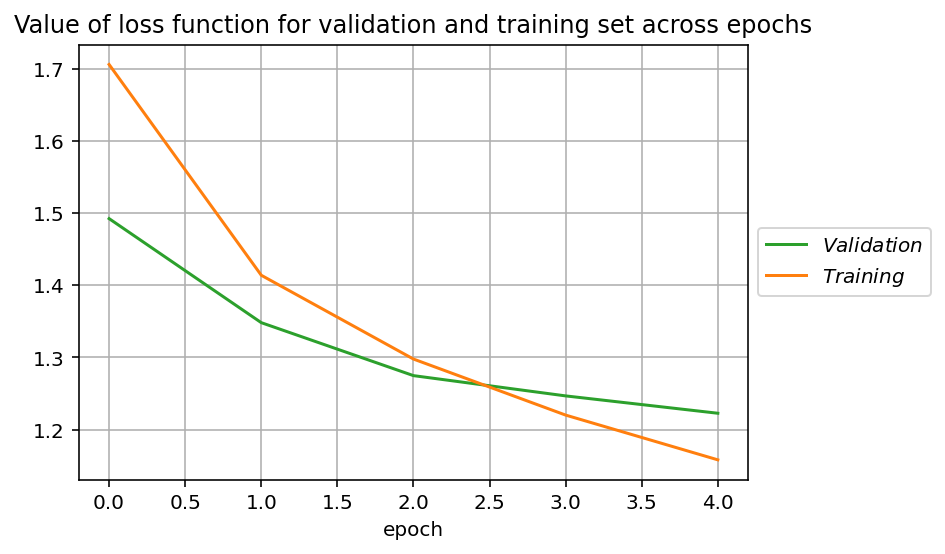

In [60]:
plt.plot(my_CNN.valid_loss_during_training, color = 'C2',label='$Validation$')
plt.plot(my_CNN.loss_during_training, color = 'C1',label='$Training$')

plt.title('Value of loss function for validation and training set across epochs')
plt.xlabel('epoch')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [61]:
train_acc = my_CNN.eval_performance(trainloader)
valid_acc = my_CNN.eval_performance(validloader)

In [63]:
print('Train accuracy is {} and Validation accuracy is{}'.format(train_acc, valid_acc))

Train accuracy is 0.6017749905586243 and Validation accuracy is0.5708598494529724


**COMMENT**

In the above plot we see how, after epoch 3, the training loss decreases faster than the validation loss, which at epoch 5 seems to be stagniting. This means that the model is close to an optimal solution (is converging/has converged). Maybe an extra epoch would be worth trying.

In any case the value of the loss function is clearly around 1.2 for both sets, which is not good. This is clear once we compute the performance of the model as the accuracies are pretty poor. Also a difference of 0.03 in both accuracies sheds a light on the fact that probably the model is starting to overfit.

## Part III. GPU-based training

As you noticed, training became excessively slow. The newtork is already quite deep and gradient evaluation becomes a heavy operation. 

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

> **Exercise:** Complete the following class, which implements the CNN training and validation using a GPU (if possible). 

**Note: Google Colab Recommended**. When running the notebook in Google Colab, make sure you first to `Edit -- Notebook settings` and **select a GPU as Hardware accelerator.**



In [64]:
class Lenet5_extended_GPU(Lenet5):
    
    #Your code here
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                #Reset Gradients!
                self.optim.zero_grad()
            
                out = self.forward(images)

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Compute gradients
                loss.backward()
                
                #SGD stem
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)               
                    
                    # Compute output for input minibatch
                    out = self.forward(images)
                    #Your code here
                    loss = self.criterion(out, labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): # Every epoch

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)
                probs = self.forward(images)

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [65]:
my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=5,lr=1e-3)
my_CNN_GPU.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.704545, Validation loss: 1.519292, Time per epoch: 10.683424 seconds
Epoch 1. Training loss: 1.428115, Validation loss: 1.373202, Time per epoch: 10.717094 seconds
Epoch 2. Training loss: 1.308999, Validation loss: 1.297557, Time per epoch: 10.588058 seconds
Epoch 3. Training loss: 1.217830, Validation loss: 1.228282, Time per epoch: 10.797794 seconds
Epoch 4. Training loss: 1.157923, Validation loss: 1.175791, Time per epoch: 10.695957 seconds


tensor(0.6111)
tensor(0.5877)


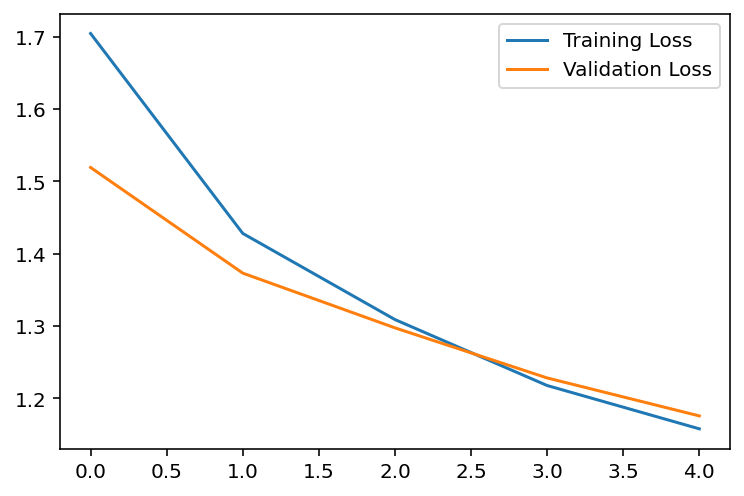

In [66]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(validloader))

With a GPU, you will see that the time per epoch roughly decreases significantly. As we train deeper and much more complex networks, **this difference grows exponentially fast**. Using GPUs is a must for lage-scale deployment.

## Part IV. Regularize the network and compare with a MLP

> **Exercise**: Now that you know how to train the CNN network, your goals are:
> - Check that the CNN is able to overfit
> - Regularize the network with both early stopping and dropout. In my experience, it is more efficient to include the dropout layers in between the final MLP layers, rather than in between convolutional layers. Note that once you include dropout, it wil take more epochs to converge. The more dropout layers, the more epochs typically you have to run. For this exercise, run at least 50 epochs.
> - Check the train/validation/test performance, plot the train and validation losses

**CHECKING THAT THE NETWORK IS ABLE TO OVERFIT**

In order to prove this it is enough to perform more epochs to the model training (5 is enough) and checking the loss funtions and the accuracies for the validation and training sets.



In [67]:
# 5 more epochs
my_CNN_GPU.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.100582, Validation loss: 1.120262, Time per epoch: 10.636595 seconds
Epoch 1. Training loss: 1.053464, Validation loss: 1.103874, Time per epoch: 10.586861 seconds
Epoch 2. Training loss: 1.010287, Validation loss: 1.100661, Time per epoch: 10.619404 seconds
Epoch 3. Training loss: 0.973387, Validation loss: 1.107047, Time per epoch: 10.635205 seconds
Epoch 4. Training loss: 0.935968, Validation loss: 1.099113, Time per epoch: 10.789223 seconds


tensor(0.6755)
tensor(0.6165)


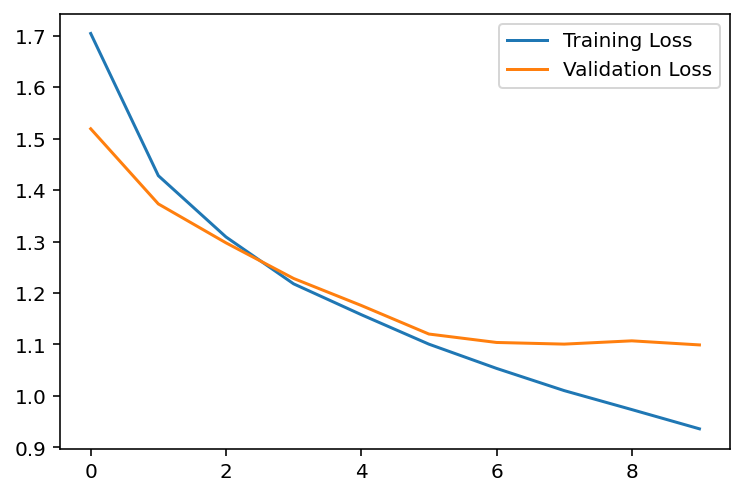

In [68]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(validloader))

**COMMENT**

In the above plot we can see how after the **sixth/seventh** epoch(considering we start counting at epoch 1) the **difference in the loss values** between the validation and the training set increases with the consecutive epochs (**difference of 0.2 at epoch 10**). 

This is a clear sign of overfitting which is backed by the **accuracies** we obtain for the two sets; which **differ by 0.06**; that is, **double the difference we got when training with just 5 epochs.**


In short, the model is able to overfit.


**REGULARIZING THE NETWORK**

I will only test different dropout configurations in the dense layers, not just because of the recommendation but because I believe that these layers, being the most deep ones, are where the model is more prompt to overfit.

To do this I create a new Lenet5 class with two additional parameters; the dropout proportion and a list with the indexes of the dense layers where we want to implement dropout.

In [80]:
class Lenet5_drop(nn.Module):
    def __init__(self,dimx,nlabels, drop_prop = .2, drop_indx = [1,2]):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.linear1 = nn.Linear(400, 120)
        
        self.linear2 = nn.Linear(120, 84)

        self.linear3 = nn.Linear(84, 10)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 

        self.final_dim = int(((dimx-4)/2-4)/2)

        #dropout initialization        
        self.drop_prop = drop_prop

        self.drop_indx = drop_indx

        self.dropout = nn.Dropout(p=self.drop_prop)


    def forward(self, x):

        x = self.conv1(x) 
        x = self.relu(x) 
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(len(x), self.final_dim**2*16)


        x = self.linear1(x)
        x = self.relu(x)
        #dropout 1
        if 1 in self.drop_indx:
          x = self.dropout(x)


        x = self.linear2(x)
        x = self.relu(x)
        #dropout 2
        if 2 in self.drop_indx:
          x = self.dropout(x)


        x = self.linear3(x)
        x = self.logsoftmax(x) 
        return x


In [78]:
class Lenet5_extended_GPU_drop(Lenet5_drop):
    
    #Your code here
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001, drop_prop = .2, drop_indx = [1,2]):
        
        super().__init__(dimx,nlabels, drop_prop, drop_indx)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                #Reset Gradients!
                self.optim.zero_grad()
            
                out = self.forward(images)

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Compute gradients
                loss.backward()
                
                #SGD stem
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)               
                    
                    # Compute output for input minibatch
                    out = self.forward(images)
                    #Your code here
                    loss = self.criterion(out, labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): # Every epoch

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)
                probs = self.forward(images)

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [ ]:
my_CNN_drop = Lenet5_extended_GPU_drop(dimx=32,nlabels=10,epochs=5,lr=1e-3, drop_prop=0.8, drop_indx=[1,2])
my_CNN_drop.trainloop(trainloader,validloader)

DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
DROPOUT!
D

In [ ]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(validloader))

### Train an MLP to compare the performance (Optional)

Train an MLP with 3-4 layers to compare the performance. Take into account that the input image has three color maps. If you stuck it into a vector, then the input dimension is 3x32x32 = 3072. An alternative is to compute the average between the three. Alternatively, you could use only one color map, or the average between three of them ...

In [ ]:
#YOUR CODE HERE